<a href="https://colab.research.google.com/github/lorenzopallante/BiomeccanicaMultiscala/blob/main/LAB/08-SMD/08-SteeredMD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Laboratorio 8
**Enhanced Sampling: Steered Molecular Dynamics (SMD)**


Authors:
    
- Prof. Marco A. Deriu (marco.deriu@polito.it)
- Lorenzo Pallante (lorenzo.pallante@polito.it)
- Eric A. Zizzi (eric.zizzi@polito.it)
- Marcello Miceli (marcello.miceli@polito.it)
- Marco Cannariato (marco.cannariato@polito.it)

# Table of Contents

1. Gromacs Setup 
2. Steered Molecular Dynamics (SMD)

    2.1 Theory recap <br>
    2.2 Practical session
    
**Learning outcomes:** 
Understand the basics and the main GROMACS settings to perform a Steered Molecular Dynamics simulation and evaluate results

# Setup

To update the maximum characters limit of the jupyter cells use the following line

In [1]:
from notebook.services.config import ConfigManager
cm = ConfigManager().update('notebook', {'limit_output': 100000000})

Since simulations are quite computational demanding, you should consider to download pre-calculated files in order to be able to follow the tutorial

In [ ]:
!gdown --folder https://drive.google.com/drive/folders/1-bwDa_PLRSbaj6Lh2x9xy1vfjsE6jThU?usp=share_link &> /dev/null
!mv SMD_solutions/* .

If you don't have GROMACS and NGLView installed on your machine or if you are using **Google COLAB**, run the following lines

**This lines should be run at the beginning of each laboratory**

In [ ]:
#@title Installing GROMACS
!apt install gromacs &> /dev/null

In [ ]:
#@title Installing NGLview
!pip install nglview  &> /dev/null
!pip install simpletraj  &> /dev/null
from google.colab import output
output.enable_custom_widget_manager()

Clone files form GitHub if you are using COLAB

In [ ]:
# IF YOU ARE USING COLAB EXECUTE THIS CELL (to copy over data repository)
!git clone https://github.com/lorenzopallante/BiomeccanicaMultiscala.git
!mv BiomeccanicaMultiscala/LAB/08-SMD/* .

If you want to download also already calculated solutions, you should run the following cell:

In [1]:
#@title Installing gdown and downloading solutions
!pip install gdown &> /dev/null
!gdown --folder https://drive.google.com/drive/folders/1-bwDa_PLRSbaj6Lh2x9xy1vfjsE6jThU?usp=share_link &> /dev/null
!mv SMD_solutions/* .

# Steered Molecular Dynamics (SMD)

## Theory Recap

**Steered Molecular Dynamcis (SMD)** applies external steering forces, applying a **constraint** (e.g. a harmonic potential), that moves along a prescribed path in the configuration space in the right direction to accelerate processes that otherwise, due to energy barriers, are too slow, overtaking the limitation of the nanosecond time scale usual in classical molecular dynamics, which is seldom long enough to observe relevant processes.

In order to guarantee that the reaction coordinate closely follows the **constraint positions**, the force constant F must be sufficiently large, which is called the **stiff-spring approximation theory**:


$$
\begin{aligned}
& F(t)=2 k(v t-s(t)) \\
& W(x(t))=\int_0^{x(t)} F(t) d x(t)
\end{aligned}
$$

<center><img src="imgs/SMD_scheme.png" width="500"></center>

In a typical investigation of a molecular process, the **reaction path**, along which the process proceeds in the configurational space, is identified (or hypothesized) and the process progress is described by the **reaction coordinate**.

The **potential of mean force (PMF)** is basically the ***free energy profile along the reaction coordinate***. PMF is determined through the Boltzmann-weighted average over all degrees of freedom other than the reaction coordinate. ​

<center><img src="imgs/PMF.png" width="500"></center>

SMD simulations are non-equilibrium processes, but PMF is an equilibrium property. The **Jarzynski’s equality** ***connects equilibrium and non-equilibrium***

$$\left<e^{-\beta {W}}\right>=e^{-\beta \Delta G} \Longleftrightarrow \Delta G=-\frac{1}{\beta} \ln \left<e^{-\beta {W}}\right>$$


## Practical Session

Basically, the steps to perform a SMD simulation are the same like in a standard MD simulation. We'll need only to add a bias potential during the production of the MD. 

<center><img src="imgs/MD_FlowChart.png" width="500"></center>

A detailed tutorial on SMD is also available in the first part of the Umbrella Sampling tutorial by Justin A. Lemkul, Ph.D.(http://www.mdtutorials.com/gmx/umbrella/index.html)

### Step 1 - Get the PDB

In this tutorial, we will use the PDB code [2BEG](https://www.rcsb.org/structure/2BEG) which is the 3D Structure of Alzheimer's Abeta(1-42) fibrils.  The structure file of the wild-type Aβ42 protofibril used in those simulations, acetylated at the N-terminus of each chain, can be found [here](http://www.mdtutorials.com/gmx/umbrella/Files/2BEG_model1_capped.pdb)

Let's have a look to the system: 

In [7]:
# download file from the RCSB database and store in the data/SMD folder
!wget -P data/ http://www.mdtutorials.com/gmx/umbrella/Files/2BEG_model1_capped.pdb

--2022-12-20 15:45:29--  http://www.mdtutorials.com/gmx/umbrella/Files/2BEG_model1_capped.pdb
Risoluzione di www.mdtutorials.com (www.mdtutorials.com)... 13.59.3.21
Connessione a www.mdtutorials.com (www.mdtutorials.com)|13.59.3.21|:80... connesso.
Richiesta HTTP inviata, in attesa di risposta... 200 OK
Lunghezza: 75951 (74K) [chemical/x-pdb]
Salvataggio in: "data/2BEG_model1_capped.pdb.2"

2BEG_model1_capped. 100%[===================>]  74,17K   276KB/s    in 0,3s    

2022-12-20 15:45:30 (276 KB/s) - "data/2BEG_model1_capped.pdb.2" salvato [75951/75951]



In [8]:
# display with nglview
import nglview as nv
from IPython.display import IFrame

with open("data/2BEG_model1_capped.pdb") as f:
    view = nv.show_file(f, ext="pdb")
view

NGLWidget()

The PDB contains 5 monomers (chains) arranged in a U-shaped way and interacting with non-bonded interactions. 

If you are more curious about this type of aggregates have a look at some publications from our group:

1. Grasso, Gianvito, Martina Rebella, Umberto Morbiducci, Jack A. Tuszynski, Andrea Danani, e Marco A. Deriu. «The Role of Structural Polymorphism in Driving the Mechanical Performance of the Alzheimer’s Beta Amyloid Fibrils». Frontiers in Bioengineering and Biotechnology 7 (24 aprile 2019): 83. https://doi.org/10.3389/fbioe.2019.00083.

2. Grasso, Gianvito, Martina Rebella, Stefano Muscat, Umberto Morbiducci, Jack Tuszynski, Andrea Danani, e Marco Deriu. «Conformational Dynamics and Stability of U-Shaped and S-Shaped Amyloid β Assemblies». International Journal of Molecular Sciences 19, fasc. 2 (14 febbraio 2018): 571. https://doi.org/10.3390/ijms19020571.

3. Miceli, Marcello, Stefano Muscat, Umberto Morbiducci, Marco Cavaglià, e Marco Agostino Deriu. «Ultrasonic Waves Effect on S-Shaped β-Amyloids Conformational Dynamics by Non-Equilibrium Molecular Dynamics». Journal of Molecular Graphics and Modelling 96 (maggio 2020): 107518. https://doi.org/10.1016/j.jmgm.2019.107518.

4. Muscat, Stefano, Lorenzo Pallante, Filip Stojceski, Andrea Danani, Gianvito Grasso, e Marco Agostino Deriu. «The Impact of Natural Compounds on S-Shaped Aβ42 Fibril: From Molecular Docking to Biophysical Characterization». International Journal of Molecular Sciences 21, fasc. 6 (16 marzo 2020): 2017. https://doi.org/10.3390/ijms21062017.


**The system we will consider for this tutorial is the dissociation of a single peptide from the growing end of an Aβ42 protofibril**

### Step 2 - Prepare GMX Topology

First, we need to create the protein topology.. 

**Which is the GROMACS command to create the protein topology?**

In [10]:
!echo -e "2 0 2 0 2 0 2 0 2 0" | gmx pdb2gmx -f data/2BEG_model1_capped.pdb -ignh -ff gromos53a6 -water spc -o complex.gro -ter

                 :-) GROMACS - gmx pdb2gmx, 2020.6-MODIFIED (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kutzner      Per Larsson    
  Justin A. Lemkul    Viveca Lindahl    Magnus Lundborg     Erik Marklund   
    Pascal Merz     Pieter Meulenhoff    Teemu Murtola       Szilard Pall   
    Sander Pronk      Roland Schulz      Michael Shirts    Alexey Shvetsov  
   Alfons Sijbers     Peter Tieleman      Jon Vincent      Teemu Virolainen 
 Christian Wennberg    Maarten Wolf      Artem Zhmurov   
                           and the project leaders:


**Note**: we needed to specify the N- and C-terminus of each chain since they were missing in the original structure

Now we have to modify the chain B protein to add a particular set of **position restraints**. 
Add the following lines at the end of the file topol_Protein_chain_B.itp: 

>#ifdef POSRES_B <br>
>#include "posre_Protein_chain_B.itp" <br>
>#endif

***We will be using chain B as an immobile reference later on in the pulling simulations, hence the need to specially position-restrain this chain only, and none of the others.***

In [11]:
%%bash
echo '
#ifdef POSRES_B
#include "posre_Protein_chain_B.itp"
#endif
'>>topol_Protein_chain_B.itp

### Step 3 - Generate Box

One must allow enough space in the pulling direction to allow for a continuous pull without interacting with the periodic images of the system. 

That is, the **minimum image convention** must be continually satisfied, and as well, the pull distance must always be less than one-half the length of the box vector along which the pulling is being conducted.

This, if you have a 10-nm box, and you pull over a distance greater than 5.0 nm, the periodic distance becomes the reference distance for the pulling, and this distance is actually less than 5.0 nm!

We will be pulling a total distance of 5.0 nm in a 12.0-nm box, to avoid the complications described above. The center of mass of the protofibril will be placed at (3.280, 2.181, 2.4775) in a box of dimensions 6.560 x 4.362 x 12. Use editconf to place the protofibril at this location:

In [12]:
!gmx editconf -f complex.gro -o newbox.gro -center 3.280 2.181 2.4775 -box 6.560 4.362 12

                :-) GROMACS - gmx editconf, 2020.6-MODIFIED (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kutzner      Per Larsson    
  Justin A. Lemkul    Viveca Lindahl    Magnus Lundborg     Erik Marklund   
    Pascal Merz     Pieter Meulenhoff    Teemu Murtola       Szilard Pall   
    Sander Pronk      Roland Schulz      Michael Shirts    Alexey Shvetsov  
   Alfons Sijbers     Peter Tieleman      Jon Vincent      Teemu Virolainen 
 Christian Wennberg    Maarten Wolf      Artem Zhmurov   
                           and the project leaders:


Check the **box** with **VMD** to check if it is set properly!

### Step 4 - Add Water

In [13]:
!gmx solvate -cp newbox.gro -cs spc216.gro -o solv.gro -p topol.top

                 :-) GROMACS - gmx solvate, 2020.6-MODIFIED (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kutzner      Per Larsson    
  Justin A. Lemkul    Viveca Lindahl    Magnus Lundborg     Erik Marklund   
    Pascal Merz     Pieter Meulenhoff    Teemu Murtola       Szilard Pall   
    Sander Pronk      Roland Schulz      Michael Shirts    Alexey Shvetsov  
   Alfons Sijbers     Peter Tieleman      Jon Vincent      Teemu Virolainen 
 Christian Wennberg    Maarten Wolf      Artem Zhmurov   
                           and the project leaders:


### Step 5 - Adding Ions

In [14]:
!touch ions.mdp #create fake mdp to only create the ions.tpr
!gmx grompp -f ions.mdp -c solv.gro -p topol.top -o ions.tpr -maxwarn 10
!echo "SOL" | gmx genion -s ions.tpr -o solv_ions.gro -p topol.top -pname NA -nname CL -neutral -conc 0.1

                 :-) GROMACS - gmx grompp, 2020.6-MODIFIED (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kutzner      Per Larsson    
  Justin A. Lemkul    Viveca Lindahl    Magnus Lundborg     Erik Marklund   
    Pascal Merz     Pieter Meulenhoff    Teemu Murtola       Szilard Pall   
    Sander Pronk      Roland Schulz      Michael Shirts    Alexey Shvetsov  
   Alfons Sijbers     Peter Tieleman      Jon Vincent      Teemu Virolainen 
 Christian Wennberg    Maarten Wolf      Artem Zhmurov   
                           and the project leaders:
 


GROMACS reminds you: "Proceed, With Fingers Crossed" (TeX)



### Step 6 - Energy Minimization

MDP file (em.mdp) for EM is available in the data folder

In [15]:
!cat data/em.mdp

; ions.mdp - used as input into grompp to generate ions.tpr
; Parameters describing what to do, when to stop and what to save
integrator  = steep     ; Algorithm (steep = steepest descent minimization)
emtol       = 1000.0    ; Stop minimization when the maximum force < 1000.0 kJ/mol/nm
emstep      = 0.01      ; Energy step size
nsteps      = 50000     ; Maximum number of (minimization) steps to perform

; Parameters describing how to find the neighbors of each atom and how to calculate the interactions
nstlist         = 1         ; Frequency to update the neighbor list and long range forces
cutoff-scheme   = Verlet    ; Buffered neighbor searching
ns_type         = grid      ; Method to determine neighbor list (simple, grid)
rlist           = 1.4       ; Cut-off for making neighbor list (short range forces)
coulombtype     = PME       ; Treatment of long range electrostatic interactions
rcoulomb        = 1.4       ; Short-range electrostatic cut-off
rvdw            = 1.4       ; Short

Create the tpr and run the energy minimization:

In [16]:
!mkdir -p 00-em/
!gmx grompp -f data/em.mdp -c solv_ions.gro -p topol.top -o 00-em/em.tpr -maxwarn 1
!gmx mdrun -v -deffnm 00-em/em

                 :-) GROMACS - gmx grompp, 2020.6-MODIFIED (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kutzner      Per Larsson    
  Justin A. Lemkul    Viveca Lindahl    Magnus Lundborg     Erik Marklund   
    Pascal Merz     Pieter Meulenhoff    Teemu Murtola       Szilard Pall   
    Sander Pronk      Roland Schulz      Michael Shirts    Alexey Shvetsov  
   Alfons Sijbers     Peter Tieleman      Jon Vincent      Teemu Virolainen 
 Christian Wennberg    Maarten Wolf      Artem Zhmurov   
                           and the project leaders:
 

Step=   18, Dmax= 9.2e-02 nm, Epot= -4.52645e+05 Fmax= 3.97601e+04, atom= 427
Step=   20, Dmax= 5.5e-02 nm, Epot= -4.54892e+05 Fmax= 1.98391e+04, atom= 429
Step=   21, Dmax= 6.7e-02 nm, Epot= -4.56413e+05 Fmax= 4.02756e+04, atom= 429
Step=   23, Dmax= 4.0e-02 nm, Epot= -4.58334e+05 Fmax= 2.08810e+04, atom= 427
Step=   24, Dmax= 4.8e-02 nm, Epot= -4.59611e+05 Fmax= 2.46153e+04, atom= 427
Step=   25, Dmax= 5.8e-02 nm, Epot= -4.60369e+05 Fmax= 3.49817e+04, atom= 427
Step=   27, Dmax= 3.5e-02 nm, Epot= -4.62357e+05 Fmax= 9.36181e+03, atom= 428
Step=   28, Dmax= 4.1e-02 nm, Epot= -4.62474e+05 Fmax= 5.25401e+04, atom= 427
Step=   29, Dmax= 5.0e-02 nm, Epot= -4.65201e+05 Fmax= 1.95399e+04, atom= 427
Step=   31, Dmax= 3.0e-02 nm, Epot= -4.66433e+05 Fmax= 1.26194e+04, atom= 427
Step=   33, Dmax= 1.8e-02 nm, Epot= -4.67327e+05 Fmax= 1.07443e+04, atom= 435
Step=   34, Dmax= 2.1e-02 nm, Epot= -4.68020e+05 Fmax= 1.92790e+04, atom= 435
Step=   35, Dmax= 2.6e-02 nm, Epot= -4.68898e+05 Fmax= 1.59808e+

Step=  156, Dmax= 1.3e-02 nm, Epot= -5.07342e+05 Fmax= 8.05912e+03, atom= 435
Step=  158, Dmax= 7.7e-03 nm, Epot= -5.07635e+05 Fmax= 2.73759e+03, atom= 435
Step=  159, Dmax= 9.2e-03 nm, Epot= -5.07729e+05 Fmax= 1.05983e+04, atom= 435
Step=  160, Dmax= 1.1e-02 nm, Epot= -5.08082e+05 Fmax= 5.12410e+03, atom= 435
Step=  162, Dmax= 6.6e-03 nm, Epot= -5.08249e+05 Fmax= 3.96494e+03, atom= 435
Step=  163, Dmax= 7.9e-03 nm, Epot= -5.08371e+05 Fmax= 6.97047e+03, atom= 435
Step=  164, Dmax= 9.5e-03 nm, Epot= -5.08545e+05 Fmax= 6.23097e+03, atom= 435
Step=  165, Dmax= 1.1e-02 nm, Epot= -5.08579e+05 Fmax= 9.60713e+03, atom= 435
Step=  166, Dmax= 1.4e-02 nm, Epot= -5.08737e+05 Fmax= 9.30527e+03, atom= 435
Step=  168, Dmax= 8.2e-03 nm, Epot= -5.09084e+05 Fmax= 2.35794e+03, atom= 435
Step=  169, Dmax= 9.9e-03 nm, Epot= -5.09173e+05 Fmax= 1.22215e+04, atom= 435
Step=  170, Dmax= 1.2e-02 nm, Epot= -5.09584e+05 Fmax= 4.86999e+03, atom= 435
Step=  172, Dmax= 7.1e-03 nm, Epot= -5.09732e+05 Fmax= 4.91695e+

Step=  297, Dmax= 7.3e-03 nm, Epot= -5.23144e+05 Fmax= 1.72718e+03, atom= 788
Step=  298, Dmax= 8.8e-03 nm, Epot= -5.23167e+05 Fmax= 1.13444e+04, atom= 788
Step=  299, Dmax= 1.1e-02 nm, Epot= -5.23436e+05 Fmax= 3.96922e+03, atom= 788
Step=  301, Dmax= 6.3e-03 nm, Epot= -5.23507e+05 Fmax= 4.83153e+03, atom= 788
Step=  302, Dmax= 7.6e-03 nm, Epot= -5.23569e+05 Fmax= 5.73221e+03, atom= 788
Step=  303, Dmax= 9.1e-03 nm, Epot= -5.23623e+05 Fmax= 6.99159e+03, atom= 788
Step=  304, Dmax= 1.1e-02 nm, Epot= -5.23666e+05 Fmax= 8.25125e+03, atom= 788
Step=  305, Dmax= 1.3e-02 nm, Epot= -5.23690e+05 Fmax= 9.99561e+03, atom= 788
Step=  307, Dmax= 7.9e-03 nm, Epot= -5.23910e+05 Fmax= 1.33083e+03, atom= 788
Step=  308, Dmax= 9.4e-03 nm, Epot= -5.24069e+05 Fmax= 1.31476e+04, atom= 788
Step=  309, Dmax= 1.1e-02 nm, Epot= -5.24299e+05 Fmax= 3.62309e+03, atom= 788
Step=  311, Dmax= 6.8e-03 nm, Epot= -5.24372e+05 Fmax= 5.88593e+03, atom= 788
Step=  312, Dmax= 8.2e-03 nm, Epot= -5.24442e+05 Fmax= 5.54647e+

Step=  439, Dmax= 5.0e-03 nm, Epot= -5.31738e+05 Fmax= 2.13403e+03, atom= 788
Step=  440, Dmax= 6.0e-03 nm, Epot= -5.31775e+05 Fmax= 6.53809e+03, atom= 788
Step=  441, Dmax= 7.2e-03 nm, Epot= -5.31853e+05 Fmax= 3.73027e+03, atom= 788
Step=  443, Dmax= 4.3e-03 nm, Epot= -5.31904e+05 Fmax= 2.32118e+03, atom= 788
Step=  444, Dmax= 5.2e-03 nm, Epot= -5.31950e+05 Fmax= 4.90762e+03, atom= 788
Step=  445, Dmax= 6.3e-03 nm, Epot= -5.32004e+05 Fmax= 3.84382e+03, atom= 788
Step=  446, Dmax= 7.5e-03 nm, Epot= -5.32021e+05 Fmax= 6.62407e+03, atom= 788
Step=  447, Dmax= 9.0e-03 nm, Epot= -5.32078e+05 Fmax= 5.94087e+03, atom= 788
Step=  449, Dmax= 5.4e-03 nm, Epot= -5.32159e+05 Fmax= 1.74081e+03, atom= 788
Step=  450, Dmax= 6.5e-03 nm, Epot= -5.32202e+05 Fmax= 7.67000e+03, atom= 788
Step=  451, Dmax= 7.8e-03 nm, Epot= -5.32298e+05 Fmax= 3.44739e+03, atom= 788
Step=  453, Dmax= 4.7e-03 nm, Epot= -5.32345e+05 Fmax= 3.06367e+03, atom= 788
Step=  454, Dmax= 5.6e-03 nm, Epot= -5.32386e+05 Fmax= 4.72930e+

What do we have to check if the minimization was correctly performed? 

We need to check if the potential reached the convergence!

In [17]:
!echo "Potential" | gmx energy -f 00-em/em.edr -o 00-em/potential.xvg

                 :-) GROMACS - gmx energy, 2020.6-MODIFIED (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kutzner      Per Larsson    
  Justin A. Lemkul    Viveca Lindahl    Magnus Lundborg     Erik Marklund   
    Pascal Merz     Pieter Meulenhoff    Teemu Murtola       Szilard Pall   
    Sander Pronk      Roland Schulz      Michael Shirts    Alexey Shvetsov  
   Alfons Sijbers     Peter Tieleman      Jon Vincent      Teemu Virolainen 
 Christian Wennberg    Maarten Wolf      Artem Zhmurov   
                           and the project leaders:
 

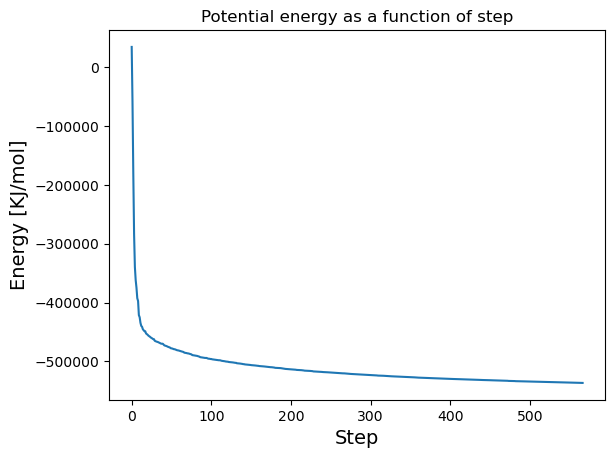

In [18]:
import matplotlib.pyplot as plt # Import from the library matplotlib  the package pyplot and alias it as plt 
import numpy as np #import the library numpy and alias it as np
'''load the data from the potential.xvg format into data, ...
define the comments as raw starting with either # or @'''
data = np.loadtxt("00-em/potential.xvg",comments=["#","@"])
step = data[:,0] #assign the first column of data to the variable step
energy = data[:,1] #assign the second column of data to the variable potential
plt.plot(step,energy) #plot the function potential(data)
plt.xlabel("Step",size=14) #assign the x label 
plt.ylabel("Energy [KJ/mol]",size=14) #assign the y label
plt.title("Potential energy as a function of step"); #assign a title 
#save the figure in png format with a resolution of 300 dot per inch "dpi" 
plt.savefig("potential.png",format="png", dpi=300)

### Step 7 - NPT Equilibration with posre

In [19]:
!mkdir -p 01-npt/
!gmx grompp -f data/npt.mdp -c 00-em/em.gro -p topol.top -r 00-em/em.gro -o 01-npt/npt.tpr -maxwarn 1
!gmx mdrun -deffnm 01-npt/npt -v 

                 :-) GROMACS - gmx grompp, 2020.6-MODIFIED (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kutzner      Per Larsson    
  Justin A. Lemkul    Viveca Lindahl    Magnus Lundborg     Erik Marklund   
    Pascal Merz     Pieter Meulenhoff    Teemu Murtola       Szilard Pall   
    Sander Pronk      Roland Schulz      Michael Shirts    Alexey Shvetsov  
   Alfons Sijbers     Peter Tieleman      Jon Vincent      Teemu Virolainen 
 Christian Wennberg    Maarten Wolf      Artem Zhmurov   
                           and the project leaders:
 

starting mdrun 'Gallium Rubidium Oxygen Manganese Argon Carbon Silicon t=   0.00000 in water'
50000 steps,    100.0 ps.
step 5500: timed with pme grid 42 28 80, coulomb cutoff 1.400: 313.9 M-cycles
step 5700: timed with pme grid 40 25 72, coulomb cutoff 1.527: 377.6 M-cycles
step 5900: timed with pme grid 40 28 72, coulomb cutoff 1.458: 347.7 M-cycles
step 6100: timed with pme grid 40 28 80, coulomb cutoff 1.435: 351.8 M-cycles
step 6300: timed with pme grid 42 28 80, coulomb cutoff 1.400: 314.6 M-cycles
              optimal pme grid 42 28 80, coulomb cutoff 1.400
step 49900, remaining wall clock time:     0 s          
Writing final coordinates.
step 50000, remaining wall clock time:     0 s          
               Core t (s)   Wall t (s)        (%)
       Time:      382.889       47.861      800.0
                 (ns/day)    (hour/ns)
Performance:      180.525        0.133

GROMACS reminds you: "The public have an insatiable curiosity to know everything, except what is worth knowi

Which quantities do we need to check to be sure that the equilibration was correctly performed? 

Check if **temperature** and **density** reached the plateau!

In [20]:
!echo -e "Temperature \n Density \n" | gmx energy -f 01-npt/npt.edr -o 01-npt/temp-dens.xvg

                 :-) GROMACS - gmx energy, 2020.6-MODIFIED (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kutzner      Per Larsson    
  Justin A. Lemkul    Viveca Lindahl    Magnus Lundborg     Erik Marklund   
    Pascal Merz     Pieter Meulenhoff    Teemu Murtola       Szilard Pall   
    Sander Pronk      Roland Schulz      Michael Shirts    Alexey Shvetsov  
   Alfons Sijbers     Peter Tieleman      Jon Vincent      Teemu Virolainen 
 Christian Wennberg    Maarten Wolf      Artem Zhmurov   
                           and the project leaders:
 

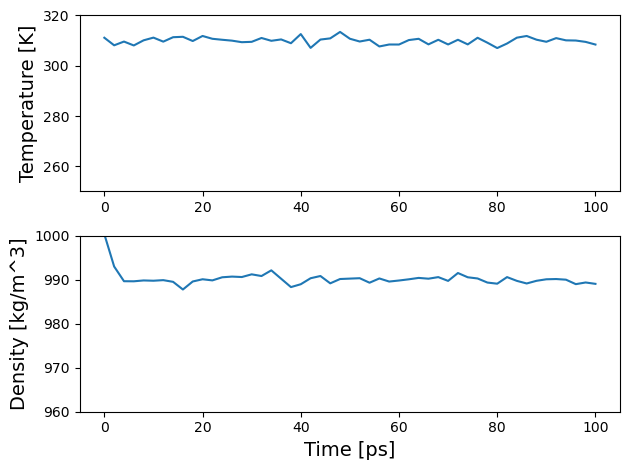

In [29]:
import matplotlib.pyplot as plt # Import from the library matplotlib  the package pyplot and alias it as plt 
import numpy as np #import the library numpy and alias it as np
'''load the data from the potential.xvg format into data, ...
define the comments as raw starting with either # or @'''
data=np.loadtxt("01-npt/temp-dens.xvg",comments=["#","@"])
time=data[:,0] #assign the first column of data to the variable step
temp=data[:,1] #assign the second column of data to the variable potential
dens=data[:,2] #assign the second column of data to the variable potential

plot,axes=plt.subplots(2,1) #plot the function potential(data)
axes[0].plot(time,temp)
axes[1].plot(time,dens)
axes[1].set_xlabel("Time [ps]",size=14) #assign the x label 
axes[0].set_ylabel("Temperature [K]",size=14) #assign the y label
axes[1].set_ylabel("Density [kg/m^3]",size=14) #assign the y label
axes[0].set_ylim(250,320)
axes[1].set_ylim(960,1000)
plt.tight_layout()
# if you want to save the figure, uncomment the following line
#plot.savefig("subplot_temp_dens.png",format="png", dpi=300)

### Step 8 - Steered Molecular Dynamics (SMD)

The idea is to pull one chain of the fibril away applying an external force while keeping fixed the position of the adjacent chain using position restraints. 

<center><img src="imgs/SystemScheme.png" width="1200"></center>

We want to pull one of the chain of the amyloid fibril along a chosen **reaction coordinate**. 

This is equivalent to ideally attach a **spring** with a certain **elastic constant** at the end of the fibril and then apply a displacemnt with a specific **force** and **velocity**.

For this example, the reaction coordinate is the **z-axis**. To generate these configurations, we must pull peptide A away from the protofibril. We will pull over the course of 500 ps of MD, saving snapshots every 1 ps. 

The pulling options for the SMD are listed below: 

<div class="alert alert-block alert-info">
; Pull code<br> 
pull                    = yes<br>
pull_ncoords            = 1         ; only one reaction coordinate <br>
pull_ngroups            = 2         ; two groups defining one reaction coordinate <br>
pull_group1_name        = Chain_A<br>
pull_group2_name        = Chain_B<br>
pull_coord1_type        = umbrella  ; harmonic potential<br>
pull_coord1_geometry    = distance  ; simple distance increase<br>
pull_coord1_dim         = N N Y     ; pull along z<br>
pull_coord1_groups      = 1 2       ; groups 1 (Chain A) and 2 (Chain B) define the reaction coordinate<br>
pull_coord1_start       = yes       ; define initial COM distance > 0<br>
pull_coord1_rate        = 0.01      ; 0.01 nm per ps = 10 nm per ns<br>
pull_coord1_k           = 1000      ; kJ mol^-1 nm^-2<br>
</b></center><div>

Remember that **#ifdef POSRES_B** statement we added to topol_B.itp a while ago? We're going to use it now. 

By **restraining peptide B** of the protofibril, we are able to more easily pull peptide A away. Due to the extensive non-covalent interactions between chains A and B, if we did not restrain chain B, we would end up simply towing the whole complex along the simulation box, which wouldn't accomplish much.

We will need to define some custom index groups for this pulling simulation. Use make_ndx:

In [24]:
!gmx editconf -f 00-em/em.tpr -o 00-em/em.pdb
!echo -e "chain A \n name 19 Chain_A \n chain B \n name 20 Chain_B \n q \n" | gmx make_ndx -f 00-em/em.pdb

                :-) GROMACS - gmx editconf, 2020.6-MODIFIED (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kutzner      Per Larsson    
  Justin A. Lemkul    Viveca Lindahl    Magnus Lundborg     Erik Marklund   
    Pascal Merz     Pieter Meulenhoff    Teemu Murtola       Szilard Pall   
    Sander Pronk      Roland Schulz      Michael Shirts    Alexey Shvetsov  
   Alfons Sijbers     Peter Tieleman      Jon Vincent      Teemu Virolainen 
 Christian Wennberg    Maarten Wolf      Artem Zhmurov   
                           and the project leaders:


In [25]:
!mkdir -p 02-pull
!gmx grompp -f data/pull.mdp -c 01-npt/npt.gro -p topol.top -r 01-npt/npt.gro -n index.ndx -t 01-npt/npt.cpt -o 02-pull/pull.tpr -maxwarn 2

                 :-) GROMACS - gmx grompp, 2020.6-MODIFIED (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kutzner      Per Larsson    
  Justin A. Lemkul    Viveca Lindahl    Magnus Lundborg     Erik Marklund   
    Pascal Merz     Pieter Meulenhoff    Teemu Murtola       Szilard Pall   
    Sander Pronk      Roland Schulz      Michael Shirts    Alexey Shvetsov  
   Alfons Sijbers     Peter Tieleman      Jon Vincent      Teemu Virolainen 
 Christian Wennberg    Maarten Wolf      Artem Zhmurov   
                           and the project leaders:
 

In [26]:
!gmx mdrun -deffnm 02-pull/pull -v

                  :-) GROMACS - gmx mdrun, 2020.6-MODIFIED (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kutzner      Per Larsson    
  Justin A. Lemkul    Viveca Lindahl    Magnus Lundborg     Erik Marklund   
    Pascal Merz     Pieter Meulenhoff    Teemu Murtola       Szilard Pall   
    Sander Pronk      Roland Schulz      Michael Shirts    Alexey Shvetsov  
   Alfons Sijbers     Peter Tieleman      Jon Vincent      Teemu Virolainen 
 Christian Wennberg    Maarten Wolf      Artem Zhmurov   
                           and the project leaders:
 

Have a look at the trajectory using **VMD**!

***Note that you must handle the periodic conditions to properly see the system's trajectory***

In [27]:
!echo "System System" | gmx trjconv -f 02-pull/pull.xtc -s 02-pull/pull.tpr -o 02-pull/noPBC.xtc -pbc mol -ur compact
!gmx editconf -f 02-pull/pull.tpr -o 02-pull/noPBC.pdb
!gmx editconf -f 02-pull/pull.tpr -o 02-pull/noPBC.gro

                 :-) GROMACS - gmx trjconv, 2020.6-MODIFIED (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kutzner      Per Larsson    
  Justin A. Lemkul    Viveca Lindahl    Magnus Lundborg     Erik Marklund   
    Pascal Merz     Pieter Meulenhoff    Teemu Murtola       Szilard Pall   
    Sander Pronk      Roland Schulz      Michael Shirts    Alexey Shvetsov  
   Alfons Sijbers     Peter Tieleman      Jon Vincent      Teemu Virolainen 
 Christian Wennberg    Maarten Wolf      Artem Zhmurov   
                           and the project leaders:


In [ ]:
import nglview as nv
traj_nopbc = nv.SimpletrajTrajectory("02-pull/noPBC.xtc", "02-pull/noPBC.gro")
view_nopbc = nv.show_simpletraj(traj_nopbc)
view_nopbc.add_representation("ball+stick",selection="water")
view_nopbc.center("sytem")
view_nopbc

There is no displacement for some time, as the force on the imaginary spring builds up until it is sufficient to overcome the restoring forces within the protofibril structure. 

Let's have a look at the force and displacement behaviour during the simulation:

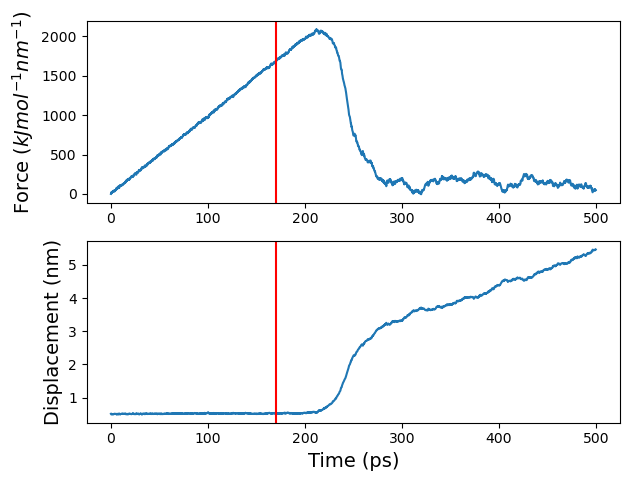

In [28]:
import matplotlib.pyplot as plt 
import numpy as np

#load data
data_f=np.loadtxt("02-pull/pull_pullf.xvg",comments=["#","@"])
data_d=np.loadtxt("02-pull/pull_pullx.xvg",comments=["#","@"])

# set variables for plot
time=data_f[:,0] 
force=data_f[:,1] 
displacement=data_d[:,1] 

# plot with matplotlib
plot,axes=plt.subplots(2,1) 
axes[0].plot(time,force)
axes[1].plot(time,displacement)
axes[1].set_xlabel("Time (ps)",size=14) #assign the x label 
axes[0].set_ylabel("Force ($kJmol^{-1}nm^{-1}$)",size=14) #assign the y label
axes[1].set_ylabel("Displacement (nm)",size=14) #assign the y label
axes[0].axvline(x = 170, color = 'r', label = 'detach')
axes[1].axvline(x = 170, color = 'r', label = 'detach')
plt.tight_layout()
# if you want to save the figure, uncomment the following line
#plot.savefig("subplot_force_disp.png",format="png", dpi=300)

Usually we are interested in the force-displacemnt graph, which allow you to estimate some mechanical properties of the system. 

**Plot the force-displacement graph using matplotlib.**

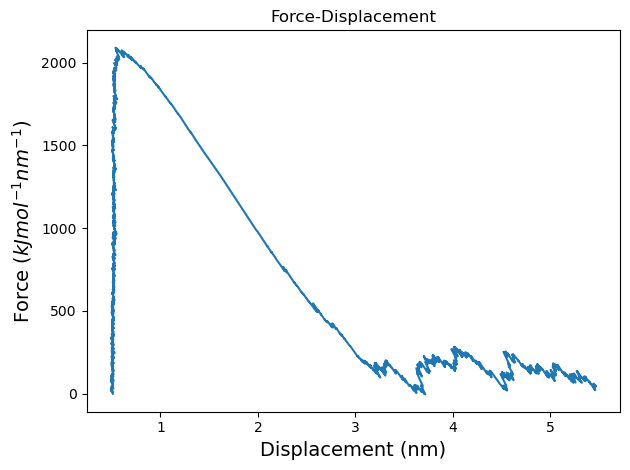

In [30]:
plt.plot(displacement,force)
plt.xlabel("Displacement (nm)",size=14) 
plt.ylabel("Force ($kJmol^{-1}nm^{-1}$)",size=14) 
plt.title("Force-Displacement")
plt.tight_layout()
# uncomment the following line to save the figure
#plt.savefig("force-displacement.png",format="png", dpi=300)

How can we compute the work done by the pulling force? 

We are also interested in evaluating the energy difference $\Delta G$ between state A (bound state) and state B (un-bound state). 

Remember the **Jarzinski equality**: 

$$\left<e^{-\beta {W}}\right>=e^{-\beta \Delta G} \Longleftrightarrow \Delta G=-\frac{1}{\beta} \ln \left<e^{-\beta {W}}\right>$$


We can extract **equilibrium information ΔG** from the ensemble of **non-equilibrium (finite-time) measurements**.

**Note:** We should run multiple indipendent SMD simulation to properly evaluate the average of the WORK to go from A to B. For this exercise, we will only use a single SMD simulation for simplicity.

In [31]:
# evaluate work done by the force
import numpy as np
work = np.trapz(force,displacement)

# calculate the free energy
temperature = 300 # K
boltzmann = 8.314 # J/mol/K
beta = 1/(boltzmann*temperature)
free_energy = -1/beta*np.log(np.exp(-beta*work))

In [32]:
# print the results
print(f"Work done by the force {work:.2f} kJ/mol")
print(f"ΔG = {free_energy:.2f} kJ/mol")

Work done by the force 3314.17 kJ/mol
ΔG = 3314.17 kJ/mol


Note that in this case the free energy is equal to the work done since we only perform a single simulation.

## Additional Materials

If you want to properly perform a SMD simulation using multiple simulation replicas to properly evaluate the free energy difference with Jarzynski, you should do something like that: 

In [2]:
# create a new directory for pulling multiple times
!mkdir -p 03-multiple_pull

In [4]:
%%bash
for i in {1..10}
do
    # create the directory for the i-esim SMD simulation
    mkdir -p 03-multiple_pull/pull_$i

    # create equilibration tpr and run equilibration
    # each replica has a different velocity distribution (gen-vel=yes in the npt.mdp file)
    gmx grompp -f data/npt.mdp -c 00-em/em.gro -p topol.top -r 00-em/em.gro -o 03-multiple_pull/pull_$i/npt.tpr -maxwarn 2 >/dev/null 2>&1
    gmx mdrun -deffnm 03-multiple_pull/pull_$i/npt -v >03-multiple_pull/pull_$i/npt_run.out 2>&1 

    # run the SMD simulation
    gmx grompp -f data/pull.mdp -c 03-multiple_pull/pull_$i/npt.gro -p topol.top -r 03-multiple_pull/pull_$i/npt.gro -n index.ndx -t 03-multiple_pull/pull_$i/npt.cpt -o 03-multiple_pull/pull_$i/pull.tpr -maxwarn 2 >/dev/null 2>&1
    gmx mdrun -deffnm 03-multiple_pull/pull_$i/pull -v >03-multiple_pull/pull_$i/pull_run.out 2>&1 

done

Error while terminating subprocess (pid=362): 


bash: riga 1:  4050 Terminato               gmx mdrun -deffnm 03-multiple_pull/pull_$i/npt -v > 03-multiple_pull/pull_$i/npt_run.out 2>&1
bash: riga 1:  4141 Terminato               gmx mdrun -deffnm 03-multiple_pull/pull_$i/npt -v > 03-multiple_pull/pull_$i/npt_run.out 2>&1
bash: riga 1:  4222 Terminato               gmx mdrun -deffnm 03-multiple_pull/pull_$i/npt -v > 03-multiple_pull/pull_$i/npt_run.out 2>&1
bash: riga 1:  4287 Terminato               gmx grompp -f data/npt.mdp -c 00-em/em.gro -p topol.top -r 00-em/em.gro -o 03-multiple_pull/pull_$i/npt.tpr -maxwarn 2 > /dev/null 2>&1
bash: riga 1:  4358 Terminato               gmx grompp -f data/npt.mdp -c 00-em/em.gro -p topol.top -r 00-em/em.gro -o 03-multiple_pull/pull_$i/npt.tpr -maxwarn 2 > /dev/null 2>&1
bash: riga 1:  4507 Terminato               gmx mdrun -deffnm 03-multiple_pull/pull_$i/npt -v > 03-multiple_pull/pull_$i/npt_run.out 2>&1
bash: riga 1:  4692 Terminato               gmx mdrun -deffnm 03-multiple_pull/pull_$i/n

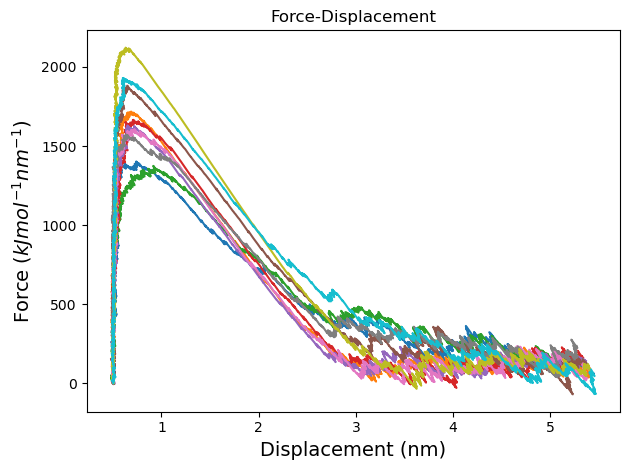

In [179]:
import matplotlib.pyplot as plt 
import numpy as np

#load data
data_f = []
data_d = []
forces = []
displacements = []

# create figure for plot
fig,ax = plt.subplots(1,1)

# load data for each simulation
for i in range(1,11):

    # load data
    data_f = np.loadtxt("03-multiple_pull/pull_" + str(i) + "/pull_pullf.xvg",comments=["#","@"])
    data_d = np.loadtxt("03-multiple_pull/pull_" + str(i) + "/pull_pullx.xvg",comments=["#","@"])

    # retrieve data
    time=data_f[:,0] 
    force = data_f[:,1]
    displacement = data_d[:,1]

    # append data to lists
    forces.append(force)
    displacements.append(displacement)

    # plot with matplotlib
    plt.plot(displacement,force)

# convert to numpy arrays
forces = np.array(forces)
displacements = np.array(displacements)

plt.xlabel("Displacement (nm)",size=14) 
plt.ylabel("Force ($kJmol^{-1}nm^{-1}$)",size=14) 
plt.title("Force-Displacement")
plt.tight_layout()

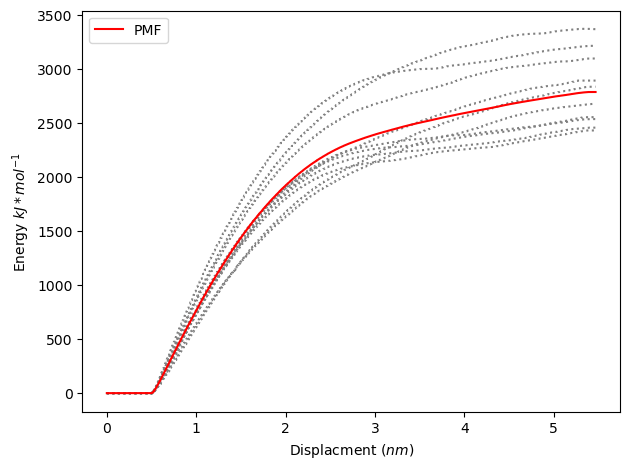

In [182]:
temperature = 300 # K
boltzmann = 8.314 # J/mol/K
#boltzmann = 0.008314 # kJ/mol/K
beta = 1/(boltzmann*temperature)

works = []
boltzmann_fac = []

# cycle of simulations
for sim in range(1,11):
    
    displacement = displacements[sim-1]
    force = forces[sim-1]

    xax = np.arange(0, np.max(displacements), np.max(displacements)/displacements.shape[1])
    #xax = np.arange(0, 4, 4/displacements.shape[1])

    work =  []
    
    for i in xax: 
        
        # calculate work
        work.append(np.trapz(force[displacement<=i],displacement[displacement<=i]))
    
    work = np.array(work)
    
    works.append(work)
    boltzmann_fac.append(np.exp(-beta*work))

    plt.plot(xax, work, color="gray",ls='dotted') 

# calculate the free energy
mean_boltz_fac = np.mean(np.array(boltzmann_fac), axis=0)

# calculate the free energy
delta_g = -1/beta*np.log(mean_boltz_fac)
plt.plot(xax, delta_g, color="red",ls='solid', label="PMF")
plt.xlabel("Displacment ($nm$)")
plt.ylabel("Energy $kJ*mol^{-1}$")
plt.legend()
plt.tight_layout()

Marcello

In [188]:
forces=[]
displacements=[]
for i in range(1,11):
    # load data
    data_f = np.loadtxt("03-multiple_pull/pull_" + str(i) + "/pull_pullf.xvg",comments=["#","@"])
    data_d = np.loadtxt("03-multiple_pull/pull_" + str(i) + "/pull_pullx.xvg",comments=["#","@"])

    time=data_f[:,0] 
    force = data_f[:,1]
    displacement = data_d[:,1]

    # append data to lists
    forces.append(force.T)
    displacements.append(displacement.T)
forces=np.array(forces)
displacements=np.array(displacements)

In [193]:
def dg(x,y,x_final,T=300,kb='kJ'):

    '''This function perform the Jarzinsky equality for a given temperatue T, 
    until a ginven point x_final
    
    x is the displacment
    y is the force
    x_final is the value to calculate the Energy
    T is the temperature
    '''
    boltzman={'kJ':8.314,'kcal':0.00198}
    
    k=boltzman['kJ']
    if x_final>np.max(x):
        print("x_final greather than the greatest displacement, x_final fill be put equal to maximum x")
        x_final=np.max(x)
    beta=1/(k*T)
    eW=0
    x=np.atleast_2d(x) # Handle the case of single vector
    y=np.atleast_2d(y) # Handle the case of single vector
    for i in range(np.shape(y)[0]):
        W=np.trapz(y[i,x[i]<x_final],x[i,x[i]<x_final])
        eW=eW+np.exp(-W*beta)
    Dg_xfinale=-1/beta*np.log(eW/len(y))
    return Dg_xfinale

In [194]:
DG=[dg(displacements,forces,j) for j in displacements[0]]

In [195]:
DG=[dg(displacements,forces,j) for j in displacements[0]]

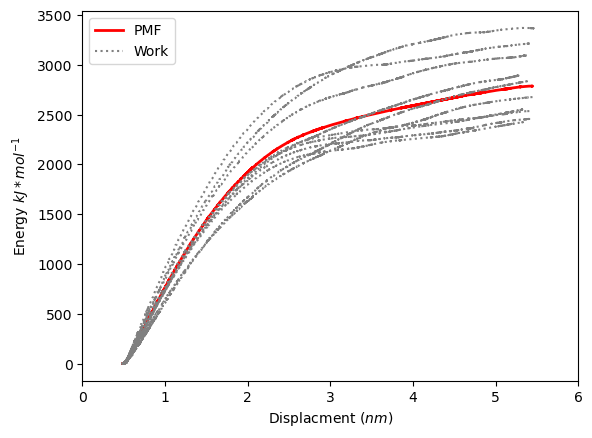

In [197]:
plt.plot(displacements[0],DG,linewidth=2,color='red')
for i,x in enumerate(displacements):
    W=[dg(x,forces[i],j) for j in x]
    plt.plot(x,W,color="gray",ls='dotted')
plt.xlabel("Displacment ($nm$)")
plt.ylabel("Energy $kJ*mol^{-1}$")
plt.xlim(0,6)
plt.legend(["PMF","Work"])